In [1]:
import random
import sys
from datetime import datetime, timedelta
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path().resolve().parent))
from paths import SCHEDULES, PREFERENCES, OUT

### Wczytanie i przygotowanie danych

In [2]:
plan = pd.read_csv(SCHEDULES / 'schedule_1.csv', sep=None, engine='python')
pref = pd.read_csv(PREFERENCES / 'preferences_1.csv')

In [3]:
plan['start_time'] = pd.to_datetime(plan['start_time'], format='%H:%M').dt.time

# Zmiana typu zajęć na ich pojemność
capacities = {
    'L': 15,
    'P': 15,
    'C': 30,
}

plan = plan[plan['type'] != 'W']
plan['type'] = plan['type'].map(capacities)
plan.rename(columns={'type': 'capacity'}, inplace=True)
plan.head(5)

,subject,specialization,capacity,Unnamed: 3,group_id,teacher,classroom,week,day,start_time
0,Przedmiot-1,G,30,30,1,Prowadzący-15,3.27a,NaN,Cz,16:45:00
1,Przedmiot-1,G,30,30,2,Prowadzący-15,3.27b,NaN,Cz,16:45:00
2,Przedmiot-1,G,30,30,3,Prowadzący-15,3.27a,NaN,Cz,18:30:00
3,Przedmiot-1,G,30,30,4,Prowadzący-15,3.27c,NaN,Cz,16:45:00
4,Przedmiot-1,G,30,30,5,Prowadzący-15,3.27b,NaN,Cz,16:45:00


### Przydatne struktury i funkcje pomocniczne


In [4]:
from collections import defaultdict

# Przydatne struktury
students = pref['student_id'].unique()
subjects = plan['subject'].unique()

# Liczba grup dla każdego przedmiotu:
# subject -> number of groups
num_groups = {}
for subject in subjects:
    n = plan[plan['subject'] == subject]['group_id'].nunique()
    num_groups[subject] = n

# Preferencje studentów dla danych grup:
# (student_id, subject, group_id): preference
pref_dict = {
    (row.student_id, row.subject, row.group_id): row.preference
    for row in pref.itertuples()
}

# Pojemności grup:
# (subject, group_id): capacity
cap_dict = {
    (row.subject, row.group_id): row.capacity
    for row in plan.itertuples()
}

# Posortowane preferencje (malejąco po przyznanych punktach):
# (student_id, subject): list of (group_id, preference)
pref_sorted = pref.sort_values(by=['student_id', 'subject', 'preference'], ascending=[True, True, False])
pref_dict_sorted = defaultdict(list) 
for row in pref_sorted.itertuples():
    pref_dict_sorted[(row.student_id, row.subject)].append((row.group_id, row.preference))

# Przedziały czasowe zajęć poszczególnych grup
# (subject, group_id) -> (day, start_time, end_time)
schedule_dict = {}
DUR = timedelta(minutes=90)
for row in plan.itertuples():
    start = datetime.combine(datetime.today(), row.start_time)
    schedule_dict[(row.subject, row.group_id)] = (
        row.day,
        row.start_time,
        (start + DUR).time()
    )


In [5]:
def conflicts(day_a, start_a, end_a, day_b, start_b, end_b):
    return (day_a == day_b) and (start_a < end_b) and (start_b < end_a)

### Tworzenie populacji

In [6]:
def generate_individual(students, subjects, cap_dict, pref_dict_sorted):
    """
    Generuje jednego osobnika (kompletne przypisanie studentów do grup)

    Dla każdego studenta, przypisuje go do najbardziej preferowanej grupy, w której
    jest jeszcze miejsce, i która nie koliduje z jego obecnym planem. 
    Jeśli nigdzie nie ma miejsca, przypisuje go do grupy z najmniejszym przepełnieniem.
    """

    occupancy = {key: 0 for key in cap_dict}
    reserved = {stu: [] for stu in students}

    groups_by_subject = {
        subject: plan[plan["subject"] == subject]["group_id"].unique().tolist()
        for subject in subjects
    }

    df = pd.DataFrame(index=students, columns=subjects)

    for student in students:
        for subject in subjects:

            groups_ok = []
            overflowed_but_ok = []

            for group_id in groups_by_subject[subject]:

                occupancy_flag = False
                conflict_flag = False

                if occupancy[(subject, group_id)] >= cap_dict.get((subject, group_id), 0):
                    occupancy_flag = True

                day, s, e = schedule_dict[(subject, group_id)]
                if any(conflicts(day, s, e, d0, s0, e0) for d0, s0, e0 in reserved[student]):
                    conflict_flag = True 

                if not occupancy_flag and not conflict_flag:    
                    groups_ok.append(group_id)
                elif occupancy_flag and not conflict_flag:
                    overflowed_but_ok.append(group_id)

            if groups_ok:
                group_id = random.choice(groups_ok)
            elif overflowed_but_ok:
                group_id = min(
                    overflowed_but_ok,
                    key=lambda g: occupancy[(subject, g)]
                )
            else:
                print(f"Konflikt: Brak grup dla studenta {student} i przedmiotu {subject}")
                group_id = random.randint(1, num_groups[subject])

            df.loc[student, subject] = group_id
            occupancy[(subject, group_id)] += 1
            reserved[student].append((day, s, e))
        
            # prefs = pref_dict_sorted[(student, subject)]
            # for group_id, _pts in prefs:

            #     # Sprawdza czy w grupie jest miejsce
            #     cap = cap_dict.get((subject, group_id), 0)
            #     if occupancy[(subject, group_id)] >= cap:
            #         continue

            #     # Sprawdza czy student nie ma w tym czasie innych zajęć
            #     day, s, e = schedule_dict[(subject, group_id)]
            #     if any(conflicts(day, s, e, d0, s0, e0) for d0, s0, e0 in reserved[student]):
            #         continue

            #     df.loc[student, subject] = group_id
            #     occupancy[(subject, group_id)] += 1
            #     reserved[student].append((day, s, e))
            #     break
            # else:
            #     # !!! To może generować kolizje w planie.
            #     # awaryjnie: w każdej grupie full – weź losową z najmniejszym przepełnieniem
            #     fallback = min(
            #         [(g, occ) for (subj, g), occ in occupancy.items() if subj == subject],
            #         key=lambda t: t[1]
            #     )[0]
            #     df.loc[student, subject] = fallback
            #     occupancy[(subject, fallback)] += 1

    return df          

In [7]:
def generate_population(size, students, subjects, num_groups):
    population = []

    for _ in range(size):
        shuffled = students.copy()
        random.shuffle(shuffled)
        ind = generate_individual(students, subjects, cap_dict, pref_dict_sorted)
        population.append(ind)
    return population

### Algorytm genetyczny

In [8]:
# TODO Zrobić żeby miało sens
def mutate(individual, num_groups, mutation_rate=0.1):
    """
    Dokonuje mutacji osobnika.

    Obecnie, losowo zmienia grupy studentom.
    """
    mutated = individual.copy()

    for student in mutated.index:
        for subject in mutated.columns:
            if random.random() < mutation_rate:
                new_group = random.randint(1, num_groups[subject])
                mutated.loc[student, subject] = new_group

    return mutated

In [9]:
def mutate_swap(individual, mutation_rate=0.1, max_attempts=50):
    mutated = individual.copy()
    reserved = {stu: set() for stu in students}
    students_list = students.tolist()

    for stu in mutated.index:
        for subj in mutated.columns:
            group_id = mutated.loc[stu, subj]
            reserved[stu].add(schedule_dict[(subj, group_id)])

    count = 0
    for stu in mutated.index:
        for subj in mutated.columns:
            if random.random() < mutation_rate:
                
                for _ in range(max_attempts):
                    subj = random.choice(subjects)
                    stu_a, stu_b = random.sample(students_list, 2)

                    if grp_a := mutated.loc[stu_a, subj] is None: 
                        continue
                    if grp_b := mutated.loc[stu_b, subj] is None:
                        continue
                    if grp_a == grp_b:
                        continue

                    day_a, s_a, e_a = schedule_dict[(subj, grp_a)]
                    day_b, s_b, e_b = schedule_dict[(subj, grp_b)]

                    if (day_a, s_a, e_a) in reserved[stu_b]:
                        continue
                    if (day_b, s_b, e_b) in reserved[stu_a]:
                        continue
                    count += 1

                    mutated.loc[stu_a, subj] = grp_b
                    mutated.loc[stu_b, subj] = grp_a

                    reserved[stu_a].remove((day_a, s_a, e_a))
                    reserved[stu_a].append((day_b, s_b, e_b))
                    reserved[stu_b].remove((day_b, s_b, e_b))
                    reserved[stu_b].append((day_a, s_a, e_a))
    # print(count)
    return mutated

In [10]:
# TODO Zrobić, żeby miało sens
def crossover(parent1, parent2):
    """
    Krzyżuje dwóch osobników i zwraca nowego.

    Obecnie, bierze pół planu od jednego rodzica i pół do drugiego
    nie patrząc na żadne warunki Xd.
    """

    students = parent1.index.tolist()
    subjects = parent1.columns.tolist()
    cut = len(students) // 2

    child = pd.DataFrame(index=students, columns=subjects)

    for i, student in enumerate(students):
        source = parent1 if i < cut else parent2
        for subject in subjects:
            child.loc[student, subject] = source.loc[student, subject]

    return child

In [11]:
# Nie jest używane, na razie
def overflow_penalty(individual_df, cap_dict, penalty_per_person=100):
    
    melted = individual_df.melt(ignore_index=False, var_name='subject', value_name='group')
    counts = melted.groupby(['subject', 'group']).size()

    penalty = 0
    for (subject, group), count in counts.items():
        cap = cap_dict.get((subject, group), 0)
        if count > cap:
            penalty += (count - cap) * penalty_per_person

    return penalty

In [12]:
def fitness(individual, pref_dict):
    total_points = 0
    max_points = pref.groupby(['student_id', 'subject'])['preference'].max().sum()

    for student in individual.index:
        for subject in individual.columns:
            group = individual.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0) 

            total_points += points
    
    return round(total_points / max_points, 2)

In [13]:
def evolve(
    students, subjects, num_groups, pref_dict,
    population_size=100, generations=100,
    mutation_rate=0.1, elite_size=2
):
    population = generate_population(population_size, students, subjects, num_groups)
    best_individual = None
    best_fitness = -1e9
    history = []

    for gen in range(generations):
        scores = list(map(float, [fitness(individual, pref_dict) for individual in population]))
        max_f = max(scores)
        history.append(max_f)

        if max_f > best_fitness:
            best_fitness = max_f
            best_individual = population[scores.index(max_f)]

        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

        elite_population = [population[i] for i in sorted_indices[:elite_size]]
        new_population = elite_population.copy()

        while len(new_population) < population_size:
            p1 = random.choice(elite_population)
            p2 = random.choice(elite_population)
            child = crossover(p1, p2)
            child = mutate(child, num_groups, mutation_rate)
            child = mutate_swap(child, mutation_rate)
            new_population.append(child)

        population = new_population

        if gen % 10 == 0 or gen == generations - 1:
            print(f"Pokolenie {gen}: najlepszy fitness = {max_f}")

    return best_individual, best_fitness, history

### Ewolucja i generowanie wyników

In [14]:
def check_conflicts(individual):
    """
    Sprawdza, czy w danym planie są kolizje zajęć.
    """
    reserved = {stu: [] for stu in students}
    for student in individual.index:
        for subject in individual.columns:
            group_id = individual.loc[student, subject]
            day, s, e = schedule_dict[(subject, group_id)]
            if any(conflicts(day, s, e, d0, s0, e0) for d0, s0, e0 in reserved[student]):
                display(reserved[student], student, subject)
                return True
            reserved[student].append((day, s, e))
    return False

In [90]:
i = generate_individual(students, subjects, cap_dict, pref_dict_sorted)
check_conflicts(i)

[('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Wt', datetime.time(9, 45), datetime.time(11, 15)),
 ('Pn', datetime.time(18, 30), datetime.time(20, 0)),
 ('Pt', datetime.time(15, 0), datetime.time(16, 30))]

'student_4'

'Przedmiot-6'

True

In [82]:
population = generate_population(20, students, subjects, num_groups)
scores = list(map(float, [fitness(individual, pref_dict) for individual in population]))
print(list(scores))

[0.45, 0.43, 0.44, 0.44, 0.43, 0.44, 0.45, 0.42, 0.44, 0.46, 0.45, 0.43, 0.43, 0.44, 0.45, 0.44, 0.42, 0.44, 0.43, 0.43]


In [83]:
x = crossover(population[0], population[1])

In [84]:
schedule_dict

{('Przedmiot-1', 1): ('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-1', 2): ('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-1', 3): ('Cz', datetime.time(18, 30), datetime.time(20, 0)),
 ('Przedmiot-1', 4): ('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-1', 5): ('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-1', 6): ('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-1', 7): ('Cz', datetime.time(18, 30), datetime.time(20, 0)),
 ('Przedmiot-1', 8): ('Cz', datetime.time(18, 30), datetime.time(20, 0)),
 ('Przedmiot-2', 1): ('Wt', datetime.time(15, 0), datetime.time(16, 30)),
 ('Przedmiot-2', 2): ('Wt', datetime.time(9, 45), datetime.time(11, 15)),
 ('Przedmiot-2', 3): ('Pt', datetime.time(9, 45), datetime.time(11, 15)),
 ('Przedmiot-2', 4): ('Wt', datetime.time(16, 45), datetime.time(18, 15)),
 ('Przedmiot-2', 5): ('Pt', datetime.time(8, 0), datetime.time(9, 30)),
 ('Przedmiot-2', 6): ('Sr', dateti

In [86]:
check_conflicts(population[0])

[('Cz', datetime.time(16, 45), datetime.time(18, 15)),
 ('Pt', datetime.time(9, 45), datetime.time(11, 15)),
 ('Pt', datetime.time(13, 15), datetime.time(14, 45)),
 ('Pn', datetime.time(15, 0), datetime.time(16, 30))]

'student_4'

'Przedmiot-6'

True

In [89]:
print(schedule_dict[('Przedmiot-1', 2)])
print(schedule_dict[('Przedmiot-2', 3)])
print(schedule_dict[('Przedmiot-3', 7)])
print(schedule_dict[('Przedmiot-4', 3)])
print(schedule_dict[('Przedmiot-6', 9)])

('Cz', datetime.time(16, 45), datetime.time(18, 15))
('Pt', datetime.time(9, 45), datetime.time(11, 15))
('Pt', datetime.time(13, 15), datetime.time(14, 45))
('Pn', datetime.time(15, 0), datetime.time(16, 30))
('Pt', datetime.time(9, 45), datetime.time(11, 15))


In [88]:
population[0].loc['student_4']

Przedmiot-1    2
Przedmiot-2    3
Przedmiot-3    7
Przedmiot-4    3
Przedmiot-6    9
Name: student_4, dtype: object

In [ ]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=40,
    mutation_rate=0.2,
    elite_size=40
)

print("Najlepszy fitness:", score)

Pokolenie 0: najlepszy fitness = 0.53
Pokolenie 10: najlepszy fitness = 0.56


In [16]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=100,
    mutation_rate=0.4,
    elite_size=30
)

print("Najlepszy fitness:", score)

Pokolenie 0: najlepszy fitness = 0.54
Pokolenie 10: najlepszy fitness = 0.56
Pokolenie 20: najlepszy fitness = 0.56
Pokolenie 30: najlepszy fitness = 0.57
Pokolenie 40: najlepszy fitness = 0.57
Pokolenie 50: najlepszy fitness = 0.57
Pokolenie 60: najlepszy fitness = 0.57
Pokolenie 70: najlepszy fitness = 0.57
Pokolenie 80: najlepszy fitness = 0.58
Pokolenie 90: najlepszy fitness = 0.58
Pokolenie 99: najlepszy fitness = 0.58
Najlepszy fitness: 0.58


In [ ]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=100,
    generations=100,
    mutation_rate=0.8,
    elite_size=30
)

print("Najlepszy fitness:", score)

Pokolenie 0: najlepszy fitness = 0.73
Pokolenie 10: najlepszy fitness = 0.75
Pokolenie 20: najlepszy fitness = 0.75
Pokolenie 30: najlepszy fitness = 0.75
Pokolenie 40: najlepszy fitness = 0.75
Pokolenie 50: najlepszy fitness = 0.75
Pokolenie 60: najlepszy fitness = 0.75
Pokolenie 70: najlepszy fitness = 0.75
Pokolenie 80: najlepszy fitness = 0.75
Pokolenie 90: najlepszy fitness = 0.75
Pokolenie 99: najlepszy fitness = 0.75
Najlepszy fitness: 0.75


In [ ]:
best.to_csv(OUT / 'output1.csv', sep=';')

In [ ]:
best.head(30)

,Przedmiot-1,Przedmiot-2,Przedmiot-3,Przedmiot-4,Przedmiot-6
student_1,4,2,2,2,10
student_2,2,4,2,8,16
student_3,3,1,5,4,17
student_4,6,3,2,2,15
student_5,7,5,2,8,1
student_6,8,1,2,6,2
student_7,3,1,4,3,9
student_8,1,3,2,8,7
student_9,6,3,3,7,2
student_10,7,6,7,6,3


### Testy i statystyki

In [ ]:
def score_per_student(df, pref_dict):

    scores = []
    max_points = pref.groupby(['student_id', 'subject'])['preference'].max()

    for student in df.index:
        student_max = max_points[student].sum()
        student_score = 0
        for subject in df.columns:
            group = df.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0) 

            student_score += points
        
        scores.append(round(student_score / student_max, 2))
    return scores
    

In [ ]:
scores = score_per_student(best, pref_dict)

[np.float64(0.98), np.float64(0.98), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.9), np.float64(0.9), np.float64(0.89), np.float64(0.89), np.float64(0.88), np.float64(0.88), np.float64(0.88), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.86), np.float64(0.85), np.float64(0.85), np.float64(0.85), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.84), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(

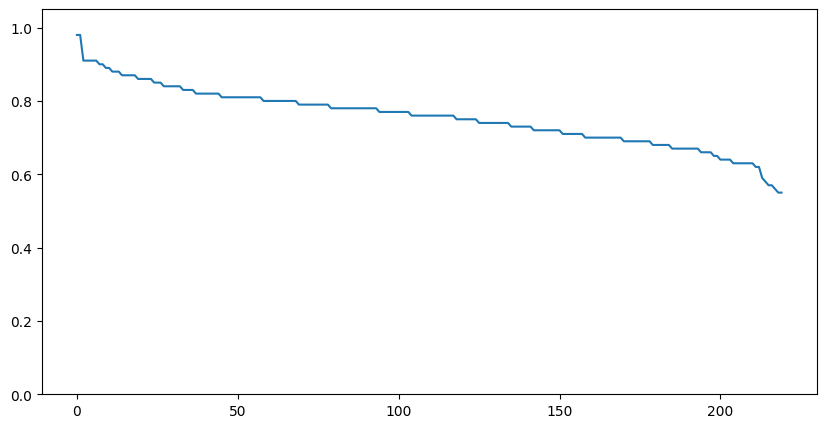

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylim(0,1.05)
plt.plot(sorted(scores, reverse=True))
print(sorted(scores, reverse=True))